In [1]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan
from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np

from jax.flatten_util import ravel_pytree

import numpy as onp
from opt_solver import AugmentedLagrangian
from dynamics import SingleIntegrator
from ergodic_metric import ErgodicMetric
from utils import BasisFunc, get_phik, get_ck
from target_distribution import TargetDistribution
from IPython.display import clear_output
import matplotlib.pyplot as plt

/Users/ia285/miniconda3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [35]:
class ErgodicTrajectoryOpt(object):
    def __init__(self, time_horizon=50) -> None:
        self.basis           = BasisFunc(n_basis=[5,5])
        self.erg_metric      = ErgodicMetric(self.basis)
        self.robot_model     = SingleIntegrator()
        n,m = self.robot_model.n, self.robot_model.m
        self.target_distr    = TargetDistribution()
        opt_args = {
            'x0' : np.array([0.84, 0.2]),
            'xf' : np.array([0.01, 1]),
            'phik' : get_phik(self.target_distr.evals, self.basis)
        }
        x = np.ones((time_horizon, self.robot_model.n)) * opt_args['x0']
        u = np.zeros((time_horizon, self.robot_model.m))
        self.init_sol = np.concatenate([x, u], axis=1) 

        @vmap
        def emap(x):
            """ Function that maps states to workspace """
            return x[:2]
        def barrier_cost(e):
            """ Barrier function to avoid robot going out of workspace """
            return np.maximum(0, e-1) + np.maximum(0, -e)
        @jit
        def loss(z, args):
            """ Traj opt loss function, not the same as erg metric """
            x, u = z[:, :n], z[:, n:]
            phik = args['phik']
            e = emap(x)
            ck = get_ck(e, self.basis)
            return self.erg_metric(ck, phik) \
                    + 0.1 * np.mean(u**2) \
                    + np.sum(barrier_cost(e))

        def eq_constr(z, args):
            """ dynamic equality constriants """
            x, u = z[:, :n], z[:, n:]
            x0 = args['x0']
            xf = args['xf']
            return np.vstack([
                x[0]-x0, 
                x[1:,:]-vmap(self.robot_model.f)(x[:-1,:], u[:-1,:]),
                x[-1] - xf
            ])

        def ineq_constr(z,args):
            """ control inequality constraints"""
            x, u = z[:, :n], z[:, n:]
            return np.abs(u) - 1.

        self.solver = AugmentedLagrangian(
                                            self.init_sol,
                                            loss, 
                                            eq_constr, 
                                            ineq_constr, 
                                            opt_args, 
                                            step_size=0.01,
                                            c=1.0
                    )
        self.solver.solve()


In [36]:
traj_opt = ErgodicTrajectoryOpt()

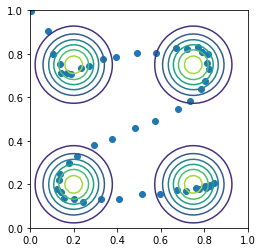

In [37]:
sol = traj_opt.solver.get_solution()
X, Y = traj_opt.target_distr.domain
P = traj_opt.target_distr.evals[0].reshape(X.shape)
clear_output(wait=True)
plt.contour(X, Y, P)
plt.scatter(sol['x'][:,0], sol['x'][:,1])
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.axis('square')
plt.show()

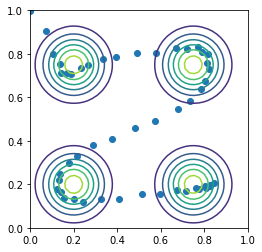

In [38]:
for _ in range(100):
    traj_opt.solver.solve(max_iter=100)
    sol = traj_opt.solver.get_solution()
    clear_output(wait=True)
    plt.contour(X, Y, P)
    plt.scatter(sol['x'][:,0], sol['x'][:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis('square')
    plt.show()

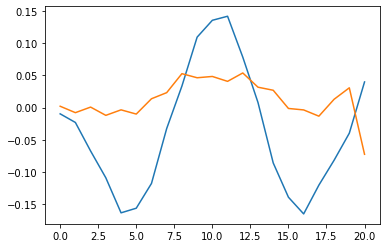

In [31]:
plt.plot(sol['lam'])

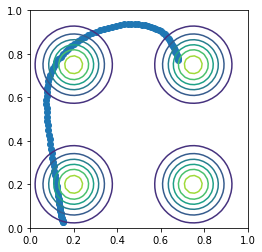

KeyboardInterrupt: 

In [25]:
traj = []
for tt in range(1000):
    
    problem.solve(args, max_iter=10)
    u = problem.solution['x']
    x0 = f(x0, u[0,:].copy())

    traj.append(x0.copy())
    args['xpast']=np.array(traj[-100:])
    args['x0'] = x0

    problem.solution['x'] = index_update(u, index[:-1,:], u[1:,:])
    problem.solution['x'] = index_update(u, index[-1,:], 0.)
    clear_output(wait=True)
    print('TI')
    if tt % 1 == 0:
        clear_output(wait=True)
        plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))
        tr = sim(x0, problem.solution['x'])[1]
        # plt.scatter(problem.solution['x'][:,0], problem.solution['x'][:,1])
        plt.scatter(tr[:,0], tr[:,1])
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.axis('square')
        plt.pause(0.001)
        plt.show()

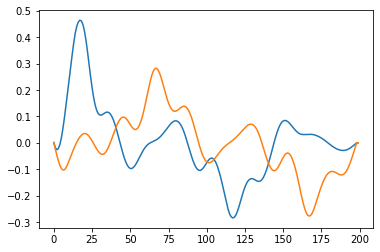

In [11]:
plt.plot(problem.solution['x'])

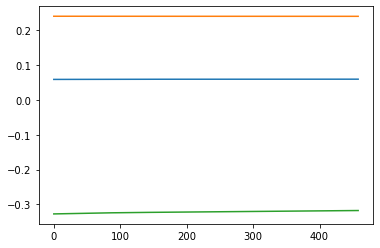

In [21]:
plt.plot(traj)